# TMDB clustering

In [68]:
# Import libraries and load data
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist

In [2]:
df = pd.read_csv('/Users/kangdi/Desktop/jupyter_notebook/TMDB Cluster/TMDB_movie_dataset_v11.csv')
# df.head()

# preprocessing

In [3]:
df.columns

Index(['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date',
       'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'tagline', 'genres',
       'production_companies', 'production_countries', 'spoken_languages'],
      dtype='object')

I drop some variables because I think they are not contributive to the model when I looked at them. But should variables overview and tagline be dropped?

In [4]:
df.drop(['id','title','backdrop_path','homepage','imdb_id','original_title','overview','poster_path','tagline'], axis=1, inplace=True)

In [5]:
# Look for missing values
df.isnull().sum()

vote_average                 0
vote_count                   0
status                       0
release_date            118290
revenue                      0
runtime                      0
adult                        0
budget                       0
original_language            0
popularity                   0
genres                  372642
production_companies    529070
production_countries    411441
spoken_languages        401197
dtype: int64

In [6]:
print(f"number of missing value in release_date takes up {df['release_date'].isnull().sum()/len(df)*100}% of the whole data.")
print(f"number of missing value in genres takes up {df['genres'].isnull().sum()/len(df)*100}% of the whole data.")
print(f"number of missing value in production_companies takes up {df['production_companies'].isnull().sum()/len(df)*100}% of the whole data.")
print(f"number of missing value in production_countries takes up {df['production_countries'].isnull().sum()/len(df)*100}% of the whole data.")
print(f"number of missing value in spoken_languages takes up {df['spoken_languages'].isnull().sum()/len(df)*100}% of the whole data.")
print(f"number of observation is {len(df)}.")

number of missing value in release_date takes up 11.74520967418437% of the whole data.
number of missing value in genres takes up 37.0002402858011% of the whole data.
number of missing value in production_companies takes up 52.532235035258466% of the whole data.
number of missing value in production_countries takes up 40.85265714393517% of the whole data.
number of missing value in spoken_languages takes up 39.83551344706861% of the whole data.
number of observation is 1007134.


As these variables are important to the algo, we can't fill in the missing values arbitarily. And it is hard to fill in the missing values for these variables in a sensible way. So I decide to drop the observations with missing values.

In [7]:
df.dropna(inplace=True)
# Reset the index after dropping rows with missing values
df.reset_index(drop=True, inplace=True)

In [8]:
# missing values are gone
df.isnull().sum()

vote_average            0
vote_count              0
status                  0
release_date            0
revenue                 0
runtime                 0
adult                   0
budget                  0
original_language       0
popularity              0
genres                  0
production_companies    0
production_countries    0
spoken_languages        0
dtype: int64

In [9]:
print(f"There are {len(df)} observations left.")

There are 298621 observations left.


In [10]:
df.describe()

,vote_average,vote_count,revenue,runtime,budget,popularity
count,298621.000000,298621.000000,2.986210e+05,298621.000000,2.986210e+05,298621.000000
mean,3.695829,69.661749,2.381120e+06,68.238459,9.154597e+05,2.731752
std,3.194134,618.403709,3.127125e+07,56.285099,8.690485e+06,14.305101
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,0.000000,0.000000,0.000000e+00,18.000000,0.000000e+00,0.600000
50%,4.900000,1.000000,0.000000e+00,82.000000,0.000000e+00,0.962000
75%,6.333000,8.000000,0.000000e+00,97.000000,0.000000e+00,2.061000
max,10.000000,34495.000000,2.923706e+09,12480.000000,8.880000e+08,2994.357000


In [11]:
df.head(len(df))

,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,original_language,popularity,genres,production_companies,production_countries,spoken_languages
0,8.364,34495,Released,2010-07-15,825532764,148,False,160000000,en,83.952,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili"
1,8.417,32571,Released,2014-11-05,701729206,169,False,165000000,en,140.241,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English
2,8.512,30619,Released,2008-07-16,1004558444,152,False,185000000,en,130.643,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin"
3,7.573,29815,Released,2009-12-15,2923706026,162,False,237000000,en,79.932,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish"
4,7.710,29166,Released,2012-04-25,1518815515,143,False,220000000,en,98.082,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298616,0.000,0,Released,2005-06-01,0,52,False,0,fr,0.600,Documentary,Saint Thomas Productions,France,French
298617,0.000,0,Released,1977-01-01,0,12,False,0,fr,0.600,Drama,"Man's Films Productions, Hélène Films","Belgium, France",French
298618,0.000,0,Released,2019-10-10,0,94,False,0,de,0.600,Documentary,anda-production GmbH,Switzerland,"German, Indonesian"
298619,0.000,0,Released,2020-01-22,0,90,False,0,de,0.647,Documentary,"Ventura Film, RSI, SRG SSR",Switzerland,"French, German"


Apparently there are some character variables and a time variable in the dataset, the next step is to convert them into numeric variables so that machine can understand.

In [12]:
# check for unique values
status_unique, status_counts = np.unique(df['status'], return_counts=True)
for status, count in zip(status_unique, status_counts):
    print(f"status: {status}, Count: {count}")

status: Canceled, Count: 1
status: In Production, Count: 691
status: Planned, Count: 219
status: Post Production, Count: 748
status: Released, Count: 296961
status: Rumored, Count: 1


In [13]:
adult_unique, adult_counts = np.unique(df['adult'], return_counts=True)
for adult, count in zip(adult_unique, adult_counts):
    print(f"adult: {adult}, Count: {count}")

adult: False, Count: 292271
adult: True, Count: 6350


In [14]:
original_language_unique, original_language_counts = np.unique(df['original_language'], return_counts=True)
for lang, count in zip(original_language_unique, original_language_counts):
    print(f"Language: {lang}, Count: {count}")


Language: ab, Count: 12
Language: af, Count: 123
Language: ak, Count: 7
Language: am, Count: 85
Language: ar, Count: 1345
Language: as, Count: 56
Language: ay, Count: 5
Language: az, Count: 315
Language: ba, Count: 8
Language: be, Count: 39
Language: bg, Count: 451
Language: bi, Count: 4
Language: bm, Count: 18
Language: bn, Count: 940
Language: bo, Count: 16
Language: bs, Count: 253
Language: ca, Count: 383
Language: ce, Count: 6
Language: cn, Count: 2526
Language: co, Count: 1
Language: cr, Count: 9
Language: cs, Count: 6022
Language: cy, Count: 43
Language: da, Count: 2226
Language: de, Count: 16597
Language: dv, Count: 16
Language: dz, Count: 13
Language: el, Count: 1898
Language: en, Count: 123449
Language: eo, Count: 8
Language: es, Count: 17902
Language: et, Count: 748
Language: eu, Count: 154
Language: fa, Count: 874
Language: ff, Count: 7
Language: fi, Count: 2010
Language: fo, Count: 8
Language: fr, Count: 21648
Language: fy, Count: 1
Language: ga, Count: 52
Language: gd, Cou

In [15]:
spoken_languages_unique, spoken_languages_counts = np.unique(df['spoken_languages'], return_counts=True)
for s_lang, count in zip(spoken_languages_unique, spoken_languages_counts):
    print(f"spoken_languages: {s_lang}, Count: {count}")

spoken_languages: Abkhazian, Arabic, English, Georgian, Russian, Count: 1
spoken_languages: Abkhazian, English, Count: 1
spoken_languages: Abkhazian, French, Georgian, English, Russian, Hungarian, Count: 1
spoken_languages: Abkhazian, French, Russian, Count: 1
spoken_languages: Abkhazian, Georgian, Russian, Turkish, Count: 1
spoken_languages: Abkhazian, German, Count: 1
spoken_languages: Abkhazian, Russian, Count: 1
spoken_languages: Abkhazian, Spanish, Count: 1
spoken_languages: Afar, Count: 1
spoken_languages: Afar, English, Count: 1
spoken_languages: Afar, English, German, Portuguese, Count: 1
spoken_languages: Afar, Korean, Indonesian, English, Count: 1
spoken_languages: Afrikaans, Count: 101
spoken_languages: Afrikaans, Amharic, Count: 1
spoken_languages: Afrikaans, Chichewa; Nyanja, Sotho, Xhosa, Zulu, English, Count: 1
spoken_languages: Afrikaans, Croatian, English, Serbian, Count: 1
spoken_languages: Afrikaans, Czech, English, Count: 1
spoken_languages: Afrikaans, Danish, Engli

In [16]:
# genres_unique, genres_counts = np.unique(df['genres'], return_counts=True)
# for genres, count in zip(genres_unique, genres_counts):
#     print(f"genres: {genres}, Count: {count}")

As we can see variables genres, production_companies, production_countries, spoken_languages have too many categories. **One-hot encoding of these Categorical columns will cause a super sparse design matrix**. It should be one of problems we should solve in this project. But for now let me drop the variables and move on.

In [17]:
df.drop(['genres','production_companies','production_countries','spoken_languages'], axis=1, inplace=True)

In [18]:
df.columns

Index(['vote_average', 'vote_count', 'status', 'release_date', 'revenue',
       'runtime', 'adult', 'budget', 'original_language', 'popularity'],
      dtype='object')

Let's move back to conversion. Now status, adult and original_language are caharacters, and release_date is time. [one-hot vs integer](https://medium.com/geekculture/machine-learning-one-hot-encoding-vs-integer-encoding-f180eb831cf1)

In [19]:
# integer encoding
LE = LabelEncoder()
df['bi_adult'] = LE.fit_transform(df['adult'])
df.drop(['adult'], axis=1, inplace=True)

In [20]:
# one hot encoding
encoder = OneHotEncoder()

encoded_data = encoder.fit_transform(df[['status', 'original_language']])
encoded_df = pd.concat([df, pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['status', 'original_language']))], axis=1)
encoded_df.drop(['status', 'original_language'], axis=1, inplace=True)
df = encoded_df

In [21]:
df.head(len(df))

,vote_average,vote_count,release_date,revenue,runtime,budget,popularity,bi_adult,status_Canceled,status_In Production,...,original_language_ur,original_language_uz,original_language_vi,original_language_wo,original_language_xh,original_language_xx,original_language_yi,original_language_yo,original_language_zh,original_language_zu
0,8.364,34495,2010-07-15,825532764,148,160000000,83.952,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.417,32571,2014-11-05,701729206,169,165000000,140.241,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.512,30619,2008-07-16,1004558444,152,185000000,130.643,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.573,29815,2009-12-15,2923706026,162,237000000,79.932,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.710,29166,2012-04-25,1518815515,143,220000000,98.082,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298616,0.000,0,2005-06-01,0,52,0,0.600,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298617,0.000,0,1977-01-01,0,12,0,0.600,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298618,0.000,0,2019-10-10,0,94,0,0.600,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298619,0.000,0,2020-01-22,0,90,0,0.647,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# time

# Convert the time variable to a pandas datetime object
df['release_date'] = pd.to_datetime(df['release_date'])

# Find the earliest time in the dataset
earliest_time = df['release_date'].min()

# Calculate the time difference between each observation and the earliest time
df['date_numeric'] = (df['release_date'] - earliest_time).dt.days
df.drop(['release_date'],axis=1, inplace=True)
df.columns

Index(['vote_average', 'vote_count', 'revenue', 'runtime', 'budget',
       'popularity', 'bi_adult', 'status_Canceled', 'status_In Production',
       'status_Planned',
       ...
       'original_language_uz', 'original_language_vi', 'original_language_wo',
       'original_language_xh', 'original_language_xx', 'original_language_yi',
       'original_language_yo', 'original_language_zh', 'original_language_zu',
       'date_numeric'],
      dtype='object', length=169)

In [63]:
df.insert(0, 'date', df['date_numeric'])

ValueError: cannot insert date, already exists

In [65]:
df.drop(['date_numeric'],axis=1, inplace=True)

KeyError: "['date_numeric'] not found in axis"

In [66]:
df.head(len(df))

,date,vote_average,vote_count,revenue,runtime,budget,popularity,bi_adult,status_Canceled,status_In Production,...,original_language_uz,original_language_vi,original_language_wo,original_language_xh,original_language_xx,original_language_yi,original_language_yo,original_language_zh,original_language_zu,cluster
0,44891,8.364,34495,825532764,148,160000000,83.952,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
1,46465,8.417,32571,701729206,169,165000000,140.241,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
2,44162,8.512,30619,1004558444,152,185000000,130.643,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
3,44679,7.573,29815,2923706026,162,237000000,79.932,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
4,45541,7.710,29166,1518815515,143,220000000,98.082,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298616,43021,0.000,0,0,52,0,0.600,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17
298617,32643,0.000,0,0,12,0,0.600,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17
298618,48265,0.000,0,0,94,0,0.600,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19
298619,48369,0.000,0,0,90,0,0.647,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19


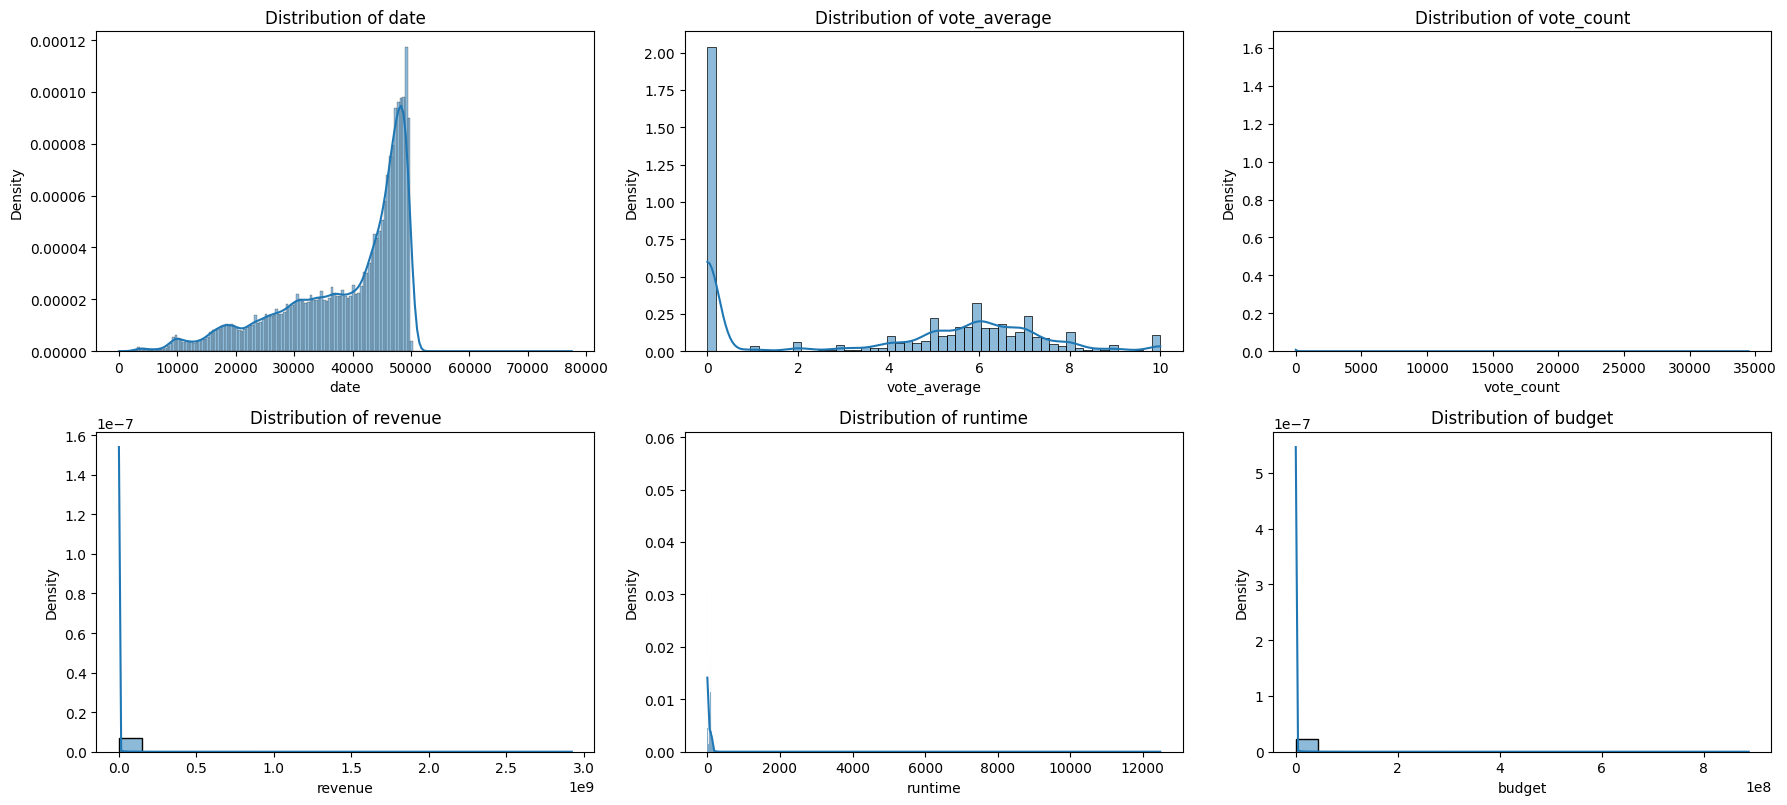

In [79]:
# Define the number of columns and rows for subplots
num_cols = 3  # Number of columns for subplots
num_rows = (len(df.columns) - 1) // num_cols + 1  # Number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 4))

axes = axes.flatten()

# Iterate over numerical variables and plot histograms
for i, col in enumerate(df.columns[0:6]):  # Exclude the first column which is assumed to be 'Class'
    sns.histplot(df[col], ax=axes[i], kde=True, stat="density")
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)

# Remove any remaining empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# K-means

In [70]:
# Scale the numerical columns
scaler = RobustScaler()
scaled_df = scaler.fit_transform(df)

# Clustering: Apply K-means clustering as an example
kmeans = KMeans(n_clusters=100,random_state=42)
clusters = kmeans.fit_predict(scaled_df)

# Add the clusters as a new column in the DataFrame
df['cluster'] = clusters

# Analyze the clusters and their characteristics
cluster_centers = kmeans.cluster_centers_


In [71]:
# Find out the most important features
# Create a DataFrame to hold cluster centroids with feature names
centroid_df = pd.DataFrame(cluster_centers, columns=df.columns)

# Calculate differences between centroids
centroid_diff = centroid_df.diff().abs().mean()

# Sort features by difference
feature_importance = centroid_diff.sort_values(ascending=False)

# Print or visualize feature importance
print(feature_importance)

revenue                 6.566309e+08
budget                  1.350773e+08
vote_count              8.933417e+02
popularity              3.767821e+01
runtime                 2.685913e-01
                            ...     
original_language_ig    3.541157e-08
original_language_ia    3.541157e-08
original_language_ts    3.541157e-08
original_language_ii    3.541157e-08
original_language_nd    3.541157e-08
Length: 170, dtype: float64


In [75]:
# Find observation close to the first movie
# Get the features of the first observation and reshape it into a 2D array
movie_1 = df.iloc[0].values.reshape(1, -1)

# Calculate the distances between the new observation and all cluster centroids
# cdist() computes distance between each pair of the two collections of inputs.
distances = cdist(movie_1, cluster_centers)

# Find the index of the closest centroid
closest_centroid_index = distances.argmin()

# Get the indices of observations belonging to the cluster corresponding to the closest centroid
cluster_indices = df[df['cluster'] == closest_centroid_index].index

print(cluster_indices)

Int64Index([0, 38, 50, 68, 85, 88, 113, 165, 377, 382, 405], dtype='int64')


In [58]:
# Show clusters
# Sort the unique cluster indices
unique_cluster_indices = sorted(df['cluster'].unique())

# Iterate over sorted unique cluster indices
for cluster_index in unique_cluster_indices:
    # Get the indices of observations belonging to the current cluster
    cluster_indices = df[df['cluster'] == cluster_index].index
    # Print the cluster index and the corresponding observation indices
    print(f"Cluster {cluster_index} indices: {cluster_indices}")



Cluster 0 indices: Int64Index([  2296,   2922,   3372,   3829,   4463,   4727,   4751,   4918,
              4931,   4964,
            ...
            298229, 298230, 298246, 298270, 298284, 298407, 298430, 298449,
            298554, 298560],
           dtype='int64', length=10268)
Cluster 1 indices: Int64Index([   514,    744,    789,    811,    831,    851,    921,   1119,
              1309,   1481,
            ...
            298518, 298532, 298538, 298562, 298567, 298575, 298576, 298596,
            298598, 298614],
           dtype='int64', length=34489)
Cluster 2 indices: Int64Index([  2817,   3444,   3610,   3855,   3866,   4180,   5149,   5263,
              5459,   5900,
            ...
            297994, 297997, 298021, 298037, 298049, 298149, 298171, 298243,
            298248, 298295],
           dtype='int64', length=1385)
Cluster 3 indices: Int64Index([  4020,   6461,   8643,   9050,   9161,   9393,  10598,  10800,
             12738,  14181,
            ...
          

Cluster 61 indices: Int64Index([  5101,   7976,  10010,  11293,  12193,  13910,  14427,  15008,
             17145,  17716,
            ...
            281360, 282605, 282685, 282854, 282898, 282958, 282959, 287262,
            289517, 296035],
           dtype='int64', length=466)
Cluster 62 indices: Int64Index([  1004,   3213,   6521,   7213,   8264,   8412,   8672,   9160,
              9212,   9377,
            ...
            297695, 297700, 298005, 298212, 298441, 298444, 298450, 298457,
            298464, 298465],
           dtype='int64', length=2533)
Cluster 63 indices: Int64Index([ 15175,  20536,  27145,  28459,  32661,  35566,  39385,  40060,
             80438,  81147,  92852,  96018, 109506, 111310, 112122, 122135,
            137471, 139680, 139778, 185391, 189315, 207580, 207587, 229788,
            254828, 256418, 275329, 276061, 277841],
           dtype='int64')
Cluster 64 indices: Int64Index([48839, 48856, 65100, 68551, 133270], dtype='int64')
Cluster 65 indices: In

1. is clustering a good way
2. what to do after clustering
3. can we do recomendation
4. is it possible to keep variables like overview and tagline
5. what to do with 'genres','production_companies','production_countries','spoken_languages'
6. is k-means good
7. if k-means, what about initial centroids
8. if k-means, the selection of number of clusters